In [1]:
import os, glob, pickle, time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, RocCurveDisplay

import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
def loads_npy_with_y(base_path, ids, y_value, normalize=True):
    start_time = time.time()
    loaded_npa_list = []
    for id in ids:
        file_path = glob.glob(f'{base_path}/{id}*.npy')[0]
        if not isinstance(file_path, str):
            raise Exception(f"could'n find id({id}) file ")
        npa = np.load(file_path)
        if normalize:
            npa = norm(npa)
        n = npa.shape[0]
        y = np.array([y_value] * n, dtype=npa.dtype)
        npa = np.concatenate([npa,y.reshape(-1,1)], axis=1)
        loaded_npa_list.append(npa)
    
    X = np.concatenate(loaded_npa_list, axis=0)

    print(f"{base_path} loaded, time : ", time.time()-start_time)
    return X

def norm(X):
    ## normalized to have zero mean and unit variance
    if np.ndim(X) != 2:
        raise Exception("from norm_batch: the input dimention is not 2")
        
    return (X - np.mean(X, axis=-1).reshape(-1,1)) / np.sqrt(np.var(X,axis=-1).reshape(-1,1) + 1e-5)



def print_results(Y, preds):
    tn, fp, fn, tp = confusion_matrix(Y[:preds.shape[0]], preds).ravel()

    accuracy = (tn + tp) / (tn+tp+fn+fp)
    recall = tp / (tp+fn)
    precision = tp / (fp+tp)
    f1_score = 2*(recall*precision) / (recall + precision)
    specificity = tn / (fp+tn)

    print("accuracy: ", round(accuracy,3))
    print("recall: ", round(recall,3))
    print("precision: ", round(precision,3))
    print("f1_score: ", round(f1_score,3))
    print("specificity: ", round(specificity,3))

    RocCurveDisplay.from_predictions(Y[:preds.shape[0]], preds)
    plt.show()
    
    return

            
def model_predict(model, X):
    ## it's too big to use the whole data
    start_time = time.time()
    data_len = X.shape[0]
    data_num_divided_1000 = data_len//1000 
    
    preds = np.array([],dtype=X.dtype)
    for i in range(data_num_divided_1000):
        start_num = i*1000
        end_num = start_num + 1000
        t_x = X[start_num:end_num]
        pred = model.predict(t_x)
        pred = np.where(pred>0.5, 1, 0)
        preds = np.append(preds, pred)

    print("preds.shape: ", preds.shape)
    print("predict time: ", time.time()-start_time)
    
    return preds


In [3]:
model = tf.keras.models.load_model('norm_model4_E10_B10_T59500_V19800_val-acc0.998.h5')

In [4]:

test_ci_ids = ["HM0004", "HM0005", "HS0001", "HS0002", "HS0009", "HS0010", "HS0012","HS0013"]

test_hi_ids = ["HL0005", "HL0075", "HL0024", "HL0034", "HL0089"]

test_ci_with_y = loads_npy_with_y("CI",test_ci_ids,1)

test_hi_with_y = loads_npy_with_y("HI",test_hi_ids,0)

test_X_with_Y = np.concatenate([test_ci_with_y, test_hi_with_y], axis=0)
np.random.shuffle(test_X_with_Y)

test_X = test_X_with_Y[:,:-1]
test_Y = test_X_with_Y[:, -1]
print(test_X.shape)

CI loaded, time :  44.08545994758606
HI loaded, time :  122.23365902900696
(56040, 64000)


In [5]:
preds = model_predict(model, test_X)

preds.shape:  (56000,)
predict time:  311.4833483695984


accuracy:  0.984
recall:  0.942
precision:  0.997
f1_score:  0.969
specificity:  0.999


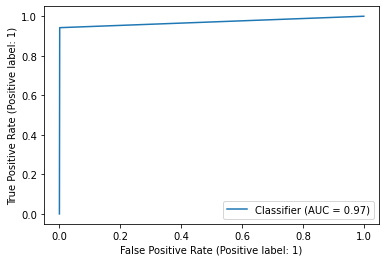

In [6]:
print_results(test_Y, preds)
del test_ci_with_y
del test_hi_with_y
del test_X_with_Y
del test_X
del test_Y

In [7]:
test2_ci_ids = ["HM0005", "HS0002", "HS0009", "HS0010", "HS0013", "HS0015", "HS0016"]

test2_hi_ids = ["HL0023", "HL0031", "HL0043", "HL0060", "HL0071", "HL0091", "HL0094", "HL0101", "HL0111", "HL0125", ]

test2_ci_with_y = loads_npy_with_y("CI",test2_ci_ids,1)

test2_hi_with_y = loads_npy_with_y("HI",test2_hi_ids,0)

test2_X_with_Y = np.concatenate([test2_ci_with_y, test2_hi_with_y], axis=0)
np.random.shuffle(test2_X_with_Y)

test2_X = test2_X_with_Y[:,:-1]
test2_Y = test2_X_with_Y[:, -1]

print(test2_X.shape)

CI loaded, time :  39.97931504249573
HI loaded, time :  149.36703443527222
(60321, 64000)


preds.shape:  (60000,)
predict time:  301.32404828071594
accuracy:  0.847
recall:  0.971
precision:  0.566
f1_score:  0.715
specificity:  0.816


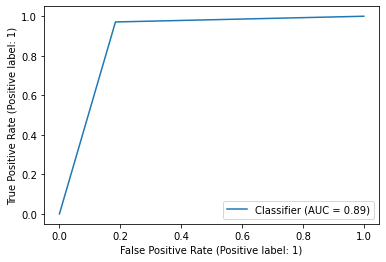

In [8]:
preds = model_predict(model, test2_X)
print_results(test2_Y, preds)
del test2_ci_with_y
del test2_hi_with_y
del test2_X_with_Y
del test2_X
del test2_Y

In [9]:
test3_ci_ids = ["HM0005", "HS0002", "HS0009", "HS0010", "HS0013", "HS0015", "HS0016"]

test3_hi_ids = ["HL0023", "HL0031", "HL0043", "HL0060", "HL0071", "HL0091", "HL0094", "HL0101", "HL0111", "HL0125", ] + \
                ["HL0004", "HL0009", "HL0012", "HL0013", "HL0014", "HL0017", "HL0129", "HL0130", "HL0134", "HL0136", "HL0138", \
                "HL0144", "HL0148", "HL0169", "HL0181", "HL0198", "HL0216", "HL0226", "HL0235", "HL0242", "HL0250"] 

test3_ci_with_y = loads_npy_with_y("CI",test3_ci_ids,1)

test3_hi_with_y = loads_npy_with_y("HI",test3_hi_ids,0)

test3_X_with_Y = np.concatenate([test3_ci_with_y, test3_hi_with_y], axis=0)
np.random.shuffle(test3_X_with_Y)

test3_X = test3_X_with_Y[:,:-1]
test3_Y = test3_X_with_Y[:, -1]

print(test3_X.shape)

CI loaded, time :  39.99596071243286
HI loaded, time :  509.3286147117615
(173737, 64000)


preds.shape:  (173000,)
predict time:  870.4232861995697
accuracy:  0.857
recall:  0.971
precision:  0.321
f1_score:  0.483
specificity:  0.848


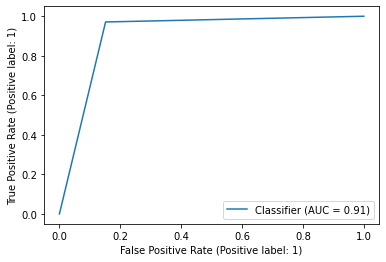

In [10]:
preds = model_predict(model, test3_X)
print_results(test3_Y, preds)
del test3_ci_with_y
del test3_hi_with_y
del test3_X_with_Y
del test3_X
del test3_Y

In [11]:
train_ci_ids = ["HM0001", "HM0002", "HS0003", "HS0004", "HS0005", "HS0006", "HS0011"]

train_hi_ids = ["HL0052", "HL0074", "HL0028", "HL0150", "HL0039", "HL0019", "HL0029"]

train_ci_with_y = loads_npy_with_y("CI",train_ci_ids,1)

train_hi_with_y = loads_npy_with_y("HI",train_hi_ids,0)

train_X_with_Y = np.concatenate([train_ci_with_y, train_hi_with_y], axis=0)
np.random.shuffle(train_X_with_Y)

train_X = train_X_with_Y[:,:-1]
train_Y = train_X_with_Y[:, -1]

CI loaded, time :  94.8337779045105
HI loaded, time :  147.67414903640747


preds.shape:  (79000,)
predict time:  397.6512541770935
accuracy:  0.998
recall:  0.999
precision:  0.996
f1_score:  0.997
specificity:  0.997


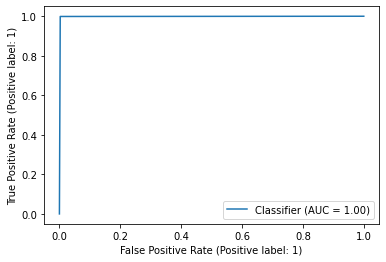

In [12]:
preds = model_predict(model, train_X)
print_results(train_Y, preds)
del train_ci_with_y
del train_hi_with_y
del train_X_with_Y
del train_X
del train_Y